In [2]:
from utils import cp_detector as cpd
from utils import data_generation as gen
from utils import statistic_calculation as stat
from utils import threshold_calculation as th

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
dataset_parameters = {
    "dataset_size": 100,
    "seq_len": 101,
    "d": 250,
    "p": 10,
    "distribution": "t-distribution",
    "k": 1,
    "cp": None,
    "nu": 3,
    "seed": 124
}

cp_parameters = {
    "alpha": 0.05,
    "scan": False,
    "data_based": False,
    "ln": False
}

In [83]:
data_with_cp, data_without_cp, t_cp_idxs = gen.generate_data(**dataset_parameters)

layer_norm = nn.LayerNorm(dataset_parameters["d"], elementwise_affine=False).float()
data_with_cp_ln = (
    layer_norm(torch.from_numpy(data_with_cp).float()).detach().numpy()
)
data_without_cp_ln = (
    layer_norm(torch.from_numpy(data_without_cp).float()).detach().numpy()
)

In [84]:
delta_sic_with, likelihood_cp_with = cpd.t_dist_data_inference(data_with_cp, dataset_parameters)
delta_sic_without, likelihood_cp_without = cpd.t_dist_data_inference(data_without_cp, dataset_parameters)

In [85]:
delta_sic_with_ln, likelihood_cp_with_ln = cpd.t_dist_data_inference(data_with_cp_ln, dataset_parameters)
delta_sic_without_ln, likelihood_cp_without_ln = cpd.t_dist_data_inference(data_without_cp_ln, dataset_parameters)

In [86]:
w=5
min_delta = int(round(min(delta_sic_with.min(), delta_sic_without.min(), delta_sic_with_ln.min(), delta_sic_without_ln.min()), 0))
max_delta = int(round(max(delta_sic_with[:, w:-w].max(), delta_sic_without[:, w:-w].max(), delta_sic_with_ln[:, w:-w].max(), delta_sic_without_ln[:, w:-w].max()), 0))


In [87]:
fp_dict = {}
fn_dict = {}
fp_ln_dict = {}
fn_ln_dict = {}
for th in range(min_delta, max_delta):
    detected_cp = np.where(delta_sic_with.min(1) > th , -1, likelihood_cp_with.argmin(1))
    detected_false_cp = np.where(delta_sic_without.min(1) > th , -1, likelihood_cp_without.argmin(1))

    fn, fp = cpd.calculate_error(detected_cp, detected_false_cp)

    detected_cp_ln = np.where(delta_sic_with_ln.min(1) > th , -1, likelihood_cp_with_ln.argmin(1))
    detected_false_cp_ln = np.where(delta_sic_without_ln.min(1) > th , -1, likelihood_cp_without_ln.argmin(1))

    fn_ln, fp_ln = cpd.calculate_error(detected_cp_ln, detected_false_cp_ln)

    fp_dict[th] = fp
    fp_ln_dict[th] = fp_ln
    fn_dict[th] = fn
    fn_ln_dict[th] = fn_ln

In [88]:
max_delta

-173

In [104]:
fn_dict[-823]

0.92

In [106]:
fp_dict[-823]

0.08

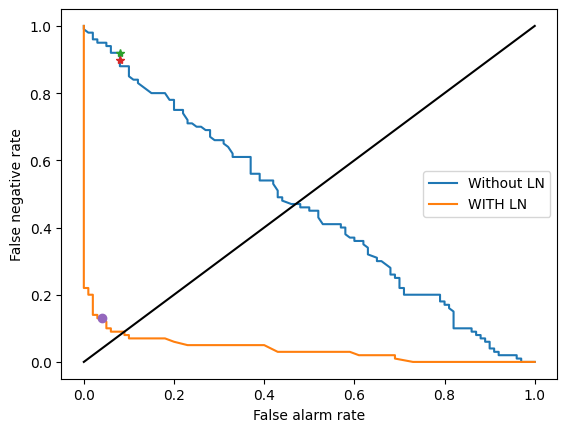

In [129]:
plt.plot(
    [value for value in fp_dict.values()],
    [value for value in fn_dict.values()],
    #"o",
    label="Without LN"
)

plt.plot(
    [value for value in fp_ln_dict.values()],
    [value for value in fn_ln_dict.values()],
    #"s",
    label="WITH LN"
)

plt.xlabel("False alarm rate")
plt.ylabel("False negative rate");
plt.legend()


plt.plot(
    fp_dict[-823], fn_dict[-823], '*')
plt.plot(
    fp_dict[-815], fn_dict[-815], '*')


plt.plot(
    fp_ln_dict[-550], fn_ln_dict[-550], 'o')
plt.plot(
    fp_ln_dict[-340], fn_ln_dict[-340], 'o')

plt.plot([0, 1], [0, 1], 'k-')


In [132]:
threshold_1 = np.quantile(delta_sic_with[:, w:-w].flatten(), 0.001)
threshold_2 = np.quantile(delta_sic_without[:, w:-w].flatten(), 0.001)

detected_cp = np.where(delta_sic_with.min(1) > threshold_2 , -1, likelihood_cp_with.argmin(1))
detected_false_cp = np.where(delta_sic_without.min(1) > threshold_2 , -1, likelihood_cp_without.argmin(1))

In [133]:
threshold_1

-823.7673174959361

In [134]:
threshold_2

-814.9305108196108

In [135]:
cpd.calculate_error(detected_cp, detected_false_cp)

(0.9, 0.08)

In [136]:
threshold_1 = np.quantile(delta_sic_with_ln[:, w:-w].flatten(), 0.001)
threshold_2 = np.quantile(delta_sic_without_ln[:, w:-w].flatten(), 0.001)

detected_cp = np.where(delta_sic_with_ln.min(1) > threshold_2 , -1, likelihood_cp_with.argmin(1))
detected_false_cp = np.where(delta_sic_without_ln.min(1) > threshold_2 , -1, likelihood_cp_without.argmin(1))

In [137]:
cpd.calculate_error(detected_cp, detected_false_cp)

(0.13, 0.04)

In [126]:
threshold_1

-550.4998856394291

In [127]:
threshold_2

-340.2763634790142